<a href="https://colab.research.google.com/github/MarcCampmanyGar/Digit_classifier-mnist-/blob/main/Digit_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import keras
from functools import partial
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

%matplotlib inline
np.random.seed(1)

In [2]:
#Importing the training and testing data
training_set = pd.read_csv("/content/sample_data/mnist_train_small.csv")
testing_set = pd.read_csv("/content/sample_data/mnist_test.csv")

In [ ]:
training_set.columns

Index(['6', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       ...
       '0.581', '0.582', '0.583', '0.584', '0.585', '0.586', '0.587', '0.588',
       '0.589', '0.590'],
      dtype='object', length=785)

In [ ]:
#Let's split the label and the pixel values from the training data
X_train = training_set.drop(['6'], axis=1).values.reshape(training_set.shape[0], 28, 28, 1)
y_train = training_set['6'].copy()

print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of testing_set is : ", testing_set.shape)


The shape of X_train is :  (19999, 28, 28, 1)
The shape of y_train is :  (19999,)
The shape of testing_set is :  (9999, 785)


In [ ]:
#It is important to have a validation set to assess the model's performance.
#We will be creating a validation set which contains atleast 6,800 images.

#first shuffling the dataset
shuffled_indices = np.random.permutation(19999)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

#Creating a validation set from the last 6,800 images
X_train, X_valid = X_train[:13199], X_train[13199:]
y_train, y_valid = y_train[:13199], y_train[13199:]

print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of X_valid is : ", X_valid.shape)
print("The shape of y_valid is : ", y_valid.shape)

The shape of X_train is :  (13199, 28, 28, 1)
The shape of y_train is :  (13199,)
The shape of X_valid is :  (6800, 28, 28, 1)
The shape of y_valid is :  (6800,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 6800 + 1) instead
  """Entry point for launching an IPython kernel.


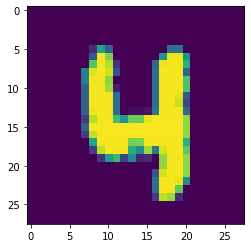

In [ ]:
random_num = np.random.random_integers(1,6800)
plt.imshow(X_train[random_num].reshape(28, 28))

In [ ]:
#Let's see how many images are there per class(digit)

print(y_train.value_counts())

1    1461
7    1362
3    1357
6    1349
9    1341
2    1313
0    1307
4    1281
8    1247
5    1181
Name: 6, dtype: int64


In [ ]:
#Each class has around 1100 to 1400 images. So the chance of class imbalance is less
#Create a basic Convolutional Neural Network model

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='same')
Digit_Recognizer = Sequential([
                        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
                        keras.layers.MaxPooling2D(pool_size=2),
                        DefaultConv2D(filters=128),
                        DefaultConv2D(filters=128),
                        keras.layers.MaxPooling2D(pool_size=2),
                        DefaultConv2D(filters=256),
                        DefaultConv2D(filters=256),
                        keras.layers.MaxPooling2D(pool_size=2),
                        keras.layers.Flatten(),
                        Dense(units=128, activation='relu'),
                        Dropout(0.5),
                        Dense(units=64, activation='relu'),
                        Dropout(0.5),
                        Dense(units=10, activation='softmax'),
                   ])

Digit_Recognizer.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
#Summarizing the model
Digit_Recognizer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)        

In [ ]:
#Training the model
filepath = "./model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]
history = Digit_Recognizer.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_valid, y_valid), 
                     verbose=1, callbacks=callbacks_list)

Epoch 1/30
204/207 [============================>.] - ETA: 0s - loss: 1.6789 - accuracy: 0.4368
Epoch 00001: accuracy improved from -inf to 0.43988, saving model to ./model.h5
207/207 [==============================] - 3s 14ms/step - loss: 1.6708 - accuracy: 0.4399 - val_loss: 0.3005 - val_accuracy: 0.9394
Epoch 2/30
206/207 [============================>.] - ETA: 0s - loss: 0.5556 - accuracy: 0.8254
Epoch 00002: accuracy improved from 0.43988 to 0.82552, saving model to ./model.h5
207/207 [==============================] - 3s 13ms/step - loss: 0.5552 - accuracy: 0.8255 - val_loss: 0.1636 - val_accuracy: 0.9550
Epoch 3/30
205/207 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8950
Epoch 00003: accuracy improved from 0.82552 to 0.89514, saving model to ./model.h5
207/207 [==============================] - 3s 14ms/step - loss: 0.3749 - accuracy: 0.8951 - val_loss: 0.1258 - val_accuracy: 0.9709
Epoch 4/30
205/207 [============================>.] - ETA: 0s - loss: 

The digit recognized by the model is :  [2]


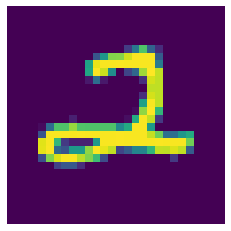

In [ ]:
#testing on an image
Digit_Recognizer = load_model('./model.h5')     #Loading the best model
plt.imshow(X_valid[3993].reshape(28, 28))
print("The digit recognized by the model is : ", Digit_Recognizer.predict_classes(X_valid[3993].reshape(1, 28, 28, 1)))
plt.axis('off')
plt.show()

In [ ]:
#The model predicts with almost 99.2% validation accuracy
#test_predictions = pd.DataFrame(Digit_Recognizer.predict_classes(testing_set), index=range(1, 28001))
#test_predictions.to_csv('./Submissions.csv', index_label=['ImageId', 'Label'])